Aim: The aim of this notebook is to do dataset cleaning, i.e. remove homes whose data is faulty. There can be many definitions of faulty. In this notebook, we will be looking at primarily the following two anomalies:
    
1. Aggregate < = Appliance
2. Aggregate < Threshold (50 units)

In [1]:
from create_matrix import *
df, dfc = create_matrix_single_region('Austin', 2014)

In [2]:
%matplotlib inline
from plot_functions import *


## 1. Homes have appliance energy > aggregate energy

In [3]:
to_remove_agg_lt_appliance = []
for appliance in ['hvac','wm','dw','mw','fridge','oven']:
    for month in range(1, 13):
        a=df.query('aggregate_%d<1.25*%s_%d' %(month, appliance, month))
        if len(a):
            for x in a.index.values:
                if x not in to_remove_agg_lt_appliance:
                    to_remove_agg_lt_appliance.append(x)
            

In [4]:
len(to_remove_agg_lt_appliance)

10

In [5]:
to_remove_agg_lt_appliance

[1714, 5109, 8967, 5786, 9737, 3916, 4864, 4352, 8059, 2965]

These 10 homes have some appliance > = aggregate; which can never be true in the real world. Such homes should not be a part of the training data! The impact of including such homes in training would be thatthe learnt latenf factors will correspond to a high appliance/aggregate energy. While true for these faulty homes, such a high appliance/aggregate ratio will lead to overprediction of appliance prediction for other homes.

### Hypothesis: Removing homes where appliance energy > = aggregate energy:
1. lead to better accuracy
2. lead to lowering of mean appliance predicted energy


### Setup
#### Before
Use all homes (including these faulty homes as well) for training; evaluation is done on all homes - these homes

#### After
Use all homes - these faulty homes for training; evaluation is done on all homes - these homes

## 2. Homes have aggregate energy < threshold (100 units)

In [6]:
less_threshold_remove = []
threshold = 100
for month in range( 1, 13):
    a = df.query('aggregate_%d<%d' %(month, threshold))
    if len(a):
        for x in a.index.values:
            if x not in less_threshold_remove:
                less_threshold_remove.append(x)

In [7]:
len(less_threshold_remove)

61

There are 61 homes where aggregate energy can be less than 100 units in some months. For reference, here is the plot showing the average monthly energy.

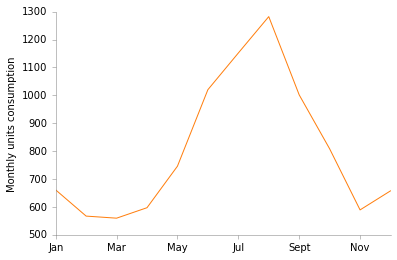

In [8]:
mean_energy = df[['aggregate_%d' %month for month in range(1, 13)]].mean().reset_index()
mean_energy.index = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
mean_energy.plot(legend=False, color=tableau20blind[2:3])
format_axes(plt.gca())
plt.ylabel("Monthly units consumption");

In [9]:
mean_energy.mean().values[0]

803.39186740222976

The mean enery consumption across homes and months is 800 units. 100 units seems too small!

In [10]:
less_threshold_remove[:5]

[1069, 2465, 3268, 4000, 4321]

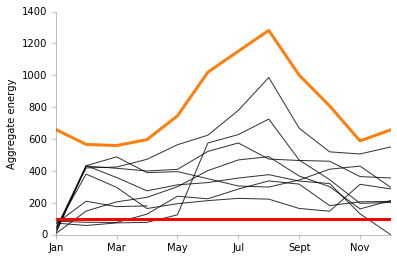

In [11]:
df.ix[less_threshold_remove[:10]][['aggregate_%d' %month for month in range(1, 13)]].T.reset_index().plot(legend=False, color='k',alpha=0.8, logy=False)
plt.axhline(100, color='r', linewidth=3)
#plt.ylim((0, 400))
mean_energy.plot(legend=False, color=tableau20blind[2:3],alpha=1,linewidth=3, ax=plt.gca())
format_axes(plt.gca())
plt.ylabel("Aggregate energy");


The above plot shows the black lines for the homes where aggregate energy consumption can go below 100 units. **Are these outliers? Should they be removed?**

## Energy breakdown performance of these "outlier" homes

I will now investigate if these "outlier" homes show bad prediction performance or not on our TF-all-appliances model case 2. All of this analysis is based on results I'd shown in the previous meeting. *I have not yet done any modification to train set, or any other parameter in the experimental setup*.

In [12]:
import pickle
tensor_all_p = pickle.load(open("predictions/o_tf_all_appliances.pkl",'r'))['tf_all_appliances']
from common import *

In [13]:
dataset = 'False'
tf_custom_all= {}
cost='abs'
sanity_num_points ={}
sensitivity ={}
best_alpha={}
best_beta = {}
best_pred = {}
best_e = {}

for appliance in tensor_all_p.keys()[:]:
    best_alpha[appliance]={}
    best_beta[appliance] = {}
    best_pred[appliance] = {}
    sensitivity[appliance] = {}
    tf_custom_all[appliance]= {}
    sanity_num_points[appliance]={}
    for case in [str(x) for x in range(2, 3)]:
        sensitivity[appliance][case] = {}
        
        sanity_num_points[appliance][case]={}
        best_error = 1e6
        for a in [str(x) for x in range(1, 11)]:
            try:
                pred = tensor_all_p[appliance][case][a][cost]
                
                if len(pred)<500:
                    continue
                if appliance=='hvac':
                    pred = pred[range(4, 10)]
                alpha, beta, error, e = compute_rmse_fraction(appliance,pred)
                assert(len(alpha)==len(beta))
                sanity_num_points[appliance][case][a]=len(alpha)
                sensitivity[appliance][case][a] = error
                if error < best_error:
                    best_error = error
                    tf_custom_all[appliance][case] = best_error
                    best_alpha[appliance]=alpha
                    best_beta[appliance]=beta
                    best_pred[appliance] = pred
                    best_e[appliance] = e
                    
            except Exception, e:
                pass

### Overall results

In [14]:
pd.DataFrame(tf_custom_all).ix['2']

aggregate    34.085106
dw            1.544899
fridge        6.545914
hvac         20.201471
mw            2.145021
oven          2.158957
wm            2.065386
Name: 2, dtype: float64

More the energy contribution, more is the error? Should we do something about this? Will revisit this with an alternative metric.

For each appliance we will be looking at the worst 10% of the entries (home, month) where worst is decided by higher error.

#### HVAC

In [15]:
f = best_e['hvac']
w = f[f>np.percentile(f, 90)].index.droplevel().values

In [16]:
o_lt = []
o_agg = []
for x in w:
    if x in less_threshold_remove:
        o_lt.append(x)
    if x in to_remove_agg_lt_appliance:
        o_agg.append(x)

In [17]:
len(set(o_lt)), len(set(o_agg))

(14, 2)

14 out of 61 homes, and 2 out of the 10 homes from the above mentioned categories of anomalous homes find a place in the worst 10% of homes for HVAC. Where are the remaining worst bits coming from? The table below shows the sorted errors.

In [18]:
f[f>np.percentile(f, 90)].sort_values()[::-1].head(20)

hvac_7   1589    279.381867
hvac_9   4590    230.450384
hvac_5   7117    213.750759
         7641    175.473859
hvac_6   2378    105.129679
hvac_8   5109    100.493877
hvac_5   9578     92.817485
hvac_8   4927     91.220640
hvac_6   8600     84.008100
         4297     80.033007
hvac_9   668      78.500284
hvac_5   8386     74.117800
         2361     74.062438
hvac_10  1185     73.381323
hvac_7   8086     62.699437
hvac_8   7017     61.976739
hvac_6   9931     57.469826
         9919     57.120013
hvac_8   7638     54.696920
         1479     54.182755
dtype: float64

The home 1589 features in none of the above two categories of anomalies. Yet, it shows a staggering 280% error for the 7th month. Let's find out why.

In [19]:
def analysis(appliance, home, month):
    analysis_ser = pd.Series([best_alpha[appliance].ix['%s_%d' %(appliance, month),home],
                             best_beta[appliance].ix['%s_%d' %(appliance, month),home],
                             df.loc[home,'%s_%d' %("aggregate",month)]])
    analysis_ser.index = ['Appliance GT % of agg','Appliance Pred % of agg', 'GT (aggregate) [kWh]']
    return analysis_ser

In [20]:
appliance = 'hvac'
month = 7
home = 1589

analysis(appliance, home, month)

Appliance GT % of agg       63.226504
Appliance Pred % of agg    342.608371
GT (aggregate) [kWh]       117.563416
dtype: float64

Oops! The predicted HVAC energy is more than 100%! Can we fix this via constraints? Let us look at some other home now.

In [21]:
analysis('hvac', 4590, 9)

Appliance GT % of agg       50.837031
Appliance Pred % of agg    281.287415
GT (aggregate) [kWh]       180.139160
dtype: float64

Again, we are predicting more than the aggregate energy! 

In [22]:
analysis('hvac', 7117, 5)

Appliance GT % of agg       20.287013
Appliance Pred % of agg    234.037772
GT (aggregate) [kWh]       106.853912
dtype: float64

**Even for the above home, our predicted seems to be more than the aggregate. Another thing to notice is that the high errors all correspond to homes having low aggregate energy.**

### Fixes needed

1. Constraint predicted appliance energy < = known aggregate energy
2. Improve performance when low aggregate energy 

#### Fridge

In [23]:
f = best_e['fridge']
w = f[f>np.percentile(f, 90)].index.droplevel().values

In [24]:
o_lt = []
o_agg = []
for x in w:
    if x in less_threshold_remove:
        o_lt.append(x)
    if x in to_remove_agg_lt_appliance:
        o_agg.append(x)

In [25]:
len(set(o_lt)), len(set(o_agg))

(16, 0)

16 out of 61 homes, and 0 out of the 10 homes from the above mentioned categories of anomalous homes find a place in the worst 10% of homes for Fridge. Where are the remaining worst bits coming from? The table below shows the sorted errors.

In [26]:
f[f>np.percentile(f, 90)].sort_values()[::-1].head(20)

fridge_5   7117    73.026539
           7641    67.104710
fridge_7   470     61.242292
fridge_10  7638    33.775511
fridge_5   9139    31.110519
fridge_11  7638    30.166741
fridge_4   9019    29.137702
fridge_3   5371    29.038644
fridge_11  5371    28.171152
fridge_4   9139    27.700027
fridge_9   7638    27.583213
fridge_1   5371    27.566073
fridge_3   9019    26.873177
fridge_7   3631    26.847185
fridge_5   9019    25.545827
fridge_2   5371    25.408739
fridge_5   3631    25.393964
           8386    25.293588
fridge_4   1403    24.967550
           347     24.558901
dtype: float64

In [27]:
analysis('fridge', 7117, 5)

Appliance GT % of agg        4.684028
Appliance Pred % of agg     77.710567
GT (aggregate) [kWh]       106.853912
dtype: float64

Ok, so, fridge energy consumed in this month for the home # 7117 is pretty high. It should be noted that this home for the same month had a high error for HVAC as well. Ofcourse, the predicted energy for this month seems to be very high. For further analysis, I will plot the 12 month aggregate and appliance energy for this home.

In [28]:
def plot_appliances_aggregate(home, appliances=['hvac']):
    temp = {} 
    temp['aggregate'] = df.ix[home][['aggregate_%d' %month for month in range(1, 13)]].values
    for appliance in appliances:
        temp[appliance] = df.ix[home][['%s_%d' %(appliance, month) for month in range(1, 13)]].values
    temp_df = pd.DataFrame(temp, index=range(1, 13))
    temp_df.plot(color=tableau20blind[::2])
    format_axes(plt.gca())
    plt.xlabel("Month of year")
    plt.ylabel("Energy (kWh)")

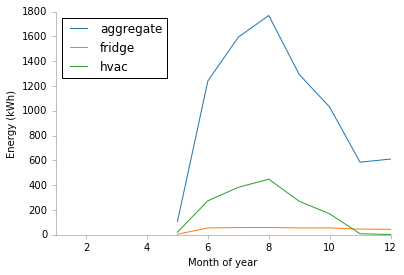

In [29]:
plot_appliances_aggregate(7117, ['fridge','hvac'])

Ok, now it makes sense. It seems that there is some data set issue and month 5 may have partial data only and thus may be causing all the trouble.

### Fixes needed
1. It is likely that homes having low energy may be due to data collection issues. 

Do we choose a higher threshold, such as 300 units to not include such homes in our analysis? Is there some other way to "fix" such data set issues?

Let us look at some other home now showing low accuracy for fridge. 

In [30]:
analysis('fridge', 470, 8)

Appliance GT % of agg       24.397197
Appliance Pred % of agg      4.745743
GT (aggregate) [kWh]       439.094147
dtype: float64

24% of energy consumed by fridge. That is insanely high! Let's look in more details.

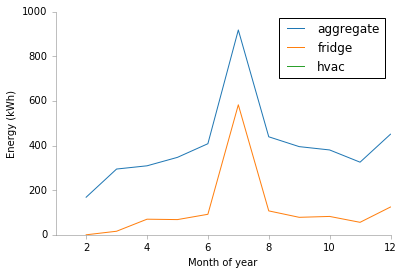

In [31]:
plot_appliances_aggregate(470, ['fridge','hvac'])

Ok, this home does not have HVAC data. However, it does feel like the fridge label is wrongly assigned. The fridge data looks more like HVAC data. This explains why the GT fraction is so high and our prediction so low as generally homes have a much lower proportion of energy consumed by fridges.

### Fixes needed
1. It is likely that some homes have wrong appliance labels.

How do we fix this!

In [32]:
analysis('fridge', 7638, 10)

Appliance GT % of agg       34.658184
Appliance Pred % of agg      0.882674
GT (aggregate) [kWh]       172.930344
dtype: float64

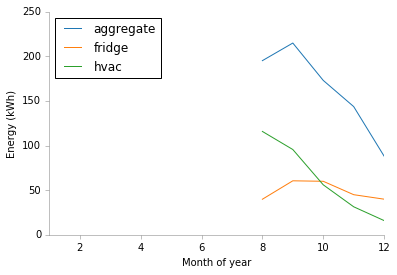

In [33]:
plot_appliances_aggregate(7638, ['fridge','hvac'])

This home only has 4 months worth data and that too mostly close to zero. This home was also flagged in our Aggregate < 100 units.

#### WM

In [34]:
f = best_e['wm']
w = f[f>np.percentile(f, 90)].index.droplevel().values

In [35]:
o_lt = []
o_agg = []
for x in w:
    if x in less_threshold_remove:
        o_lt.append(x)
    if x in to_remove_agg_lt_appliance:
        o_agg.append(x)

In [36]:
len(set(o_lt)), len(set(o_agg))

(6, 1)

6 out of 61 homes, and 1 out of the 10 homes from the above mentioned categories of anomalous homes find a place in the worst 10% of homes for WM. Where are the remaining worst bits coming from? The table below shows the sorted errors.

In [37]:
f[f>np.percentile(f, 90)].sort_values()[::-1].head(20)

wm_3   9215    56.365192
wm_2   9215    54.896668
wm_4   9215    39.896042
wm_1   7951    23.078530
wm_2   7951    20.389158
wm_3   7951    16.588971
wm_11  7951    12.585268
wm_12  7951    11.714458
wm_4   645      5.616138
wm_12  645      5.330565
wm_4   9982     4.760445
wm_9   645      4.656930
wm_3   645      4.604906
wm_11  645      4.404151
wm_5   645      4.323611
wm_12  3886     4.147500
wm_5   7641     4.032369
wm_10  645      4.017243
wm_7   645      3.787556
wm_1   7587     3.516882
dtype: float64

A few offending homes seem to have poor prediction across many months. Given that WM error hovers around 2%, these numbers are staggering high.

In [38]:
analysis('wm', 9215, 3)

Appliance GT % of agg       57.104960
Appliance Pred % of agg      0.739768
GT (aggregate) [kWh]       424.831787
dtype: float64

Washing machine consuming 57% of household energy! That's crazy high.

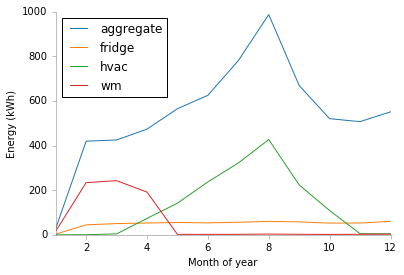

In [39]:
plot_appliances_aggregate(9215, ['fridge','hvac','wm'])

For most months, the HVAC consumption seems to be fairly standard. What happened in months 1-4! Clearly some dataset issue? Or, did the home become a laundry?

In [40]:
analysis('wm', 7951, 1)

Appliance GT % of agg        23.657484
Appliance Pred % of agg       0.578955
GT (aggregate) [kWh]       1200.703003
dtype: float64

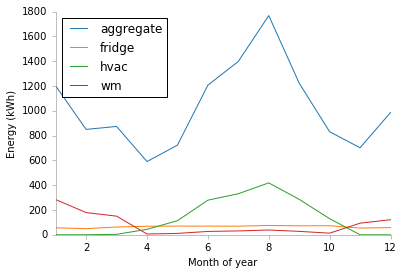

In [41]:
plot_appliances_aggregate(7951, ['fridge','hvac','wm'])

Ok, somewhat again a similar trend. But, seriously a quarter of the energy in winters going into WM?